<a href="https://colab.research.google.com/github/joccy-code/Random-Forest/blob/main/Lab_06_Random_Forest_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Problem:` Early Prediction of Laboratory Test Abnormalities from Electronic Admission Records Using the Random Forest Algorithm

`1. import labraries`

In [1]:
import pandas as pd

`2. load dataset`

In [2]:
ds=pd.read_csv("healthcare.csv")

`3. Quick EDA`

In [3]:
ds.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,1/31/2024,Matthew Smith,Sons and Miller,Blue Cross,18856.28131,328,Urgent,2/2/2024,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,8/20/2019,Samantha Davies,Kim Inc,Medicare,33643.32729,265,Emergency,8/26/2019,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,9/22/2022,Tiffany Mitchell,Cook PLC,Aetna,27955.09608,205,Emergency,10/7/2022,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,11/18/2020,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.78241,450,Elective,12/18/2020,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,9/19/2022,Kathleen Hanna,White-White,Aetna,14238.31781,458,Urgent,10/9/2022,Penicillin,Abnormal


In [4]:
ds.isnull().sum()

,0
Name,0
Age,0
Gender,0
Blood Type,0
Medical Condition,0
Date of Admission,0
Doctor,0
Hospital,0
Insurance Provider,0
Billing Amount,0


In [5]:
ds.shape

(999, 15)

4. `Basic cleaning`

In [6]:
print(ds.columns.tolist())

['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']


In [7]:
# Convert date columns to datetime
ds["Date of Admission"] = pd.to_datetime(ds["Date of Admission"], errors='coerce')
ds["Discharge Date"] = pd.to_datetime(ds["Discharge Date"], errors='coerce')

# Extract useful date-based features
ds["Admission_Year"] = ds["Date of Admission"].dt.year
ds["Admission_Month"] = ds["Date of Admission"].dt.month
ds["Admission_Day"] = ds["Date of Admission"].dt.day

# Calculate length of stay
ds["Length_of_Stay"] = (ds["Discharge Date"] - ds["Date of Admission"]).dt.days

# Drop identifier-like columns
ds = ds.drop(columns=["Name", "Date of Admission", "Discharge Date"])

`5. Define features / target`

In [8]:
target = "Test Results"   # Abnormal / Normal
features = [
    "Age", "Gender", "Blood Type", "Medical Condition",
    "Doctor", "Hospital", "Insurance Provider",
    "Billing Amount", "Room Number", "Admission Type", "Medication",
    "Admission_Year", "Admission_Month", "Admission_Day",
    "Length_of_Stay"
]
X = ds[features]
y = ds[target]

 6. `Train-test split`

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (799, 15)
Test shape: (200, 15)


7. `Preprocessing pipeline`

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
numeric_features = ["Age", "Billing Amount", "Room Number",
                    "Admission_Year", "Admission_Month",
                    "Admission_Day", "Length_of_Stay"]

categorical_features = [
    "Gender", "Blood Type", "Medical Condition", "Doctor",
    "Hospital", "Insurance Provider", "Admission Type", "Medication"
]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

 8. `Build the model pipeline`

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", model)
])

9. `Train the model`

In [12]:
print("\nTraining model...")
pipeline.fit(X_train, y_train)
print("Training completed.")


Training model...
Training completed.


8. Model evaluation

In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate using multiclass-safe metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')   # macro average across all classes
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

print("\n--- Evaluation Metrics ---")
print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


--- Evaluation Metrics ---
Accuracy: 0.385
Precision (macro): 0.3837393162393163
Recall (macro): 0.3805860805860806
F1-score (macro): 0.37329768001293245

Confusion Matrix:
 [[39 13 18]
 [31 19 15]
 [30 16 19]]

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.39      0.56      0.46        70
Inconclusive       0.40      0.29      0.34        65
      Normal       0.37      0.29      0.32        65

    accuracy                           0.39       200
   macro avg       0.38      0.38      0.37       200
weighted avg       0.38      0.39      0.38       200



`Confusion Matrix Heatmap`

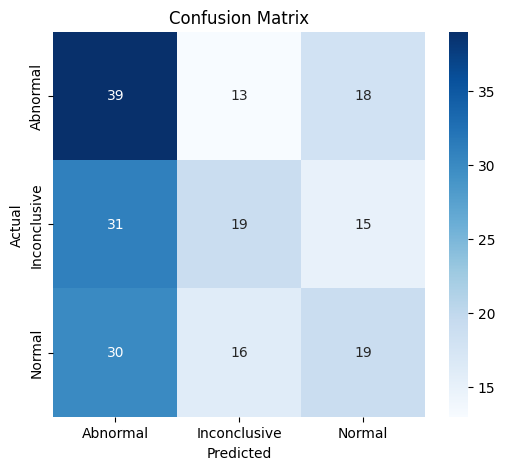

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

`ROC Curve (for binary classification)`

* Since your target has 3 classes, a standard ROC curve (which is for binary classification) won’t work directly.
* For multiclass ROC, you can do one of these:
     * One-vs-Rest (OvR) ROC curves
     * Treat each class as positive vs all others (one-vs-rest)
     * Plot a separate ROC curve for each class

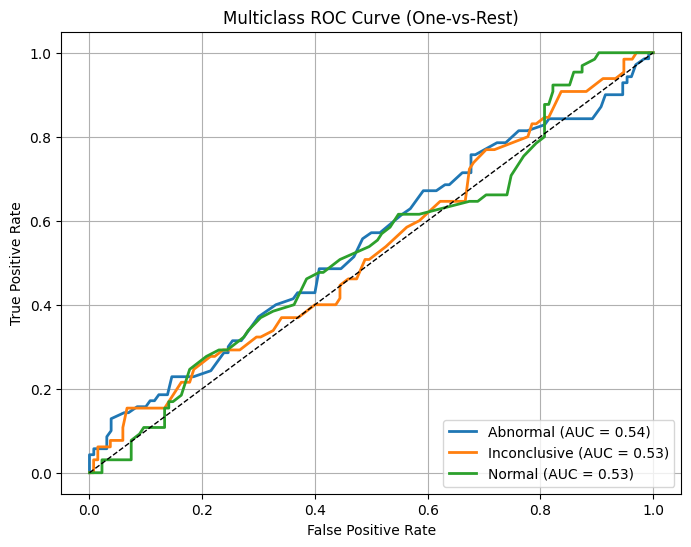

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Classes
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize the output
y_test_bin = label_binarize(y_test, classes=classes)
y_score = pipeline.predict_proba(X_test)  # shape = (n_samples, n_classes)

# Plot ROC curve for each class
plt.figure(figsize=(8,6))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


* Macro / micro average ROC
     * Compute overall ROC by averaging across classes
     * Useful if you want a single AUC score

In [16]:
from sklearn.metrics import roc_auc_score
y_test_bin = label_binarize(y_test, classes=classes)
y_score = pipeline.predict_proba(X_test)
# Micro-average AUC
auc_micro = roc_auc_score(y_test_bin, y_score, average='micro')
# Macro-average AUC
auc_macro = roc_auc_score(y_test_bin, y_score, average='macro')
print(f"Micro-average AUC = {auc_micro:.2f}")
print(f"Macro-average AUC = {auc_macro:.2f}")


Micro-average AUC = 0.53
Macro-average AUC = 0.53


9. Feature importances

In [17]:
from sklearn.pipeline import Pipeline
cat = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
cat_names = cat.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(cat_names)
importances = pipeline.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop Feature Importances:")
print(importance_df.head(15))


Top Feature Importances:
                       Feature  Importance
1               Billing Amount    0.051114
2                  Room Number    0.049278
0                          Age    0.048796
5                Admission_Day    0.045531
6               Length_of_Stay    0.044635
4              Admission_Month    0.038664
3               Admission_Year    0.031119
1615     Admission Type_Urgent    0.011682
8                  Gender_Male    0.011418
1614  Admission Type_Emergency    0.011340
1608  Insurance Provider_Aetna    0.010776
1610  Insurance Provider_Cigna    0.010670
1620     Medication_Penicillin    0.010620
1619    Medication_Paracetamol    0.010555
1613   Admission Type_Elective    0.010514


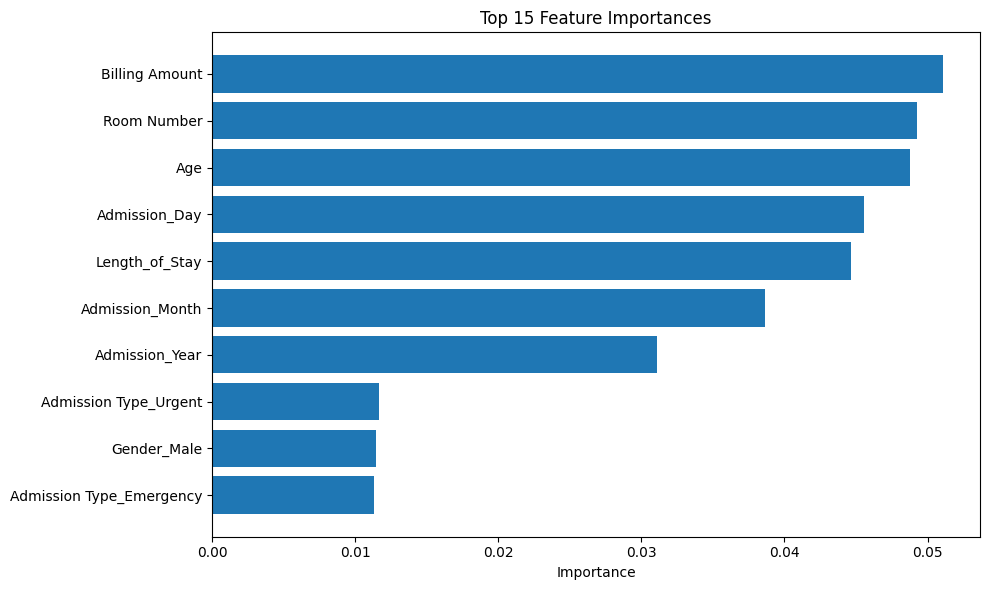

In [18]:
import matplotlib.pyplot as plt
# Get feature names
cat = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_names = cat.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

# Get importances
importances = pipeline.named_steps['classifier'].feature_importances_

# Create DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'].head(10)[::-1], feat_imp['Importance'].head(10)[::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


# 10. `Save model`

In [19]:
import joblib
joblib.dump(pipeline, "RandomForest_LabModel.pkl")
print("\nModel saved: RandomForest_LabModel.pkl")


Model saved: RandomForest_LabModel.pkl
